# GRU model (Gated Recurrent Unit)

In [1]:
from data_loader import load_names_from_web, holdout_split

In [25]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GRU, Dense, Dropout
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # StandardScaler
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, Flatten, Dropout, InputLayer
from tensorflow.keras.models import Sequential

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch


## load and prepare data

In [3]:
dfraw = load_names_from_web(category="national", hide_pre_1937=True, use_existing_files=True)
dfraw.head()

,state,year,name,M/F,count
0,US,2000,Emily,F,25957
1,US,2000,Hannah,F,23085
2,US,2000,Madison,F,19968
3,US,2000,Ashley,F,17998
4,US,2000,Sarah,F,17712


In [4]:
df1 = dfraw.copy()
df1['name_g'] = df1['name'] + '_' + df1['M/F']
df1.drop(columns=['state', 'name'], inplace=True)
df1.columns = ['year', 'gender', 'count', 'name']
df1.head()

,year,gender,count,name
0,2000,F,25957,Emily_F
1,2000,F,23085,Hannah_F
2,2000,F,19968,Madison_F
3,2000,F,17998,Ashley_F
4,2000,F,17712,Sarah_F


In [5]:
# for now, lets just look at names that have been used continuously throughout the years.
# for later iterations, can replace this cell with another cell creating df2
unique_years = df1['year'].nunique()
complete_records = df1.groupby('name').filter(lambda x: x['year'].nunique() == unique_years)
df2 = complete_records.reset_index(drop=True)
print(df2.shape, 'names: ', df2['name'].nunique())
df2.head()

(202702, 4) names:  2357


,year,gender,count,name
0,2000,F,25957,Emily_F
1,2000,F,23085,Hannah_F
2,2000,F,17712,Sarah_F
3,2000,F,17265,Samantha_F
4,2000,F,15711,Jessica_F


In [6]:
# add some features
df3 = df2.copy()
df3['gender'] = df3['gender'].map({'M': 0, 'F': 1})

df3['count_sum'] = df3.groupby('year')['count'].transform('sum')

df3['perc'] = 100 * df3['count'] / df3['count_sum']

df3.sort_values(by=['name', 'year'], inplace=True)
for lag in [1, 2, 3, 5, 10, 20]:
    df3[f'diff{lag}'] = df3.groupby('name')['perc'].diff(lag)

df3['accel'] = df3.groupby('name')['diff1'].diff()

vowels = 'aeiouAEIOU'
df3['starts_with_vowel'] = df3['name'].apply(lambda x: x[0] in vowels).astype(int)
df3['ends_with_vowel'] = df3['name'].apply(lambda x: x[-3] in vowels).astype(int)
df3['ends_with_y'] = df3['name'].apply(lambda x: x[-3]=='y').astype(int)
df3['ends_with_ah'] = df3['name'].apply(lambda x: x[-4:-2]=='ah').astype(int)
df3.head()

,year,gender,count,name,count_sum,perc,diff1,diff2,diff3,diff5,diff10,diff20,accel,starts_with_vowel,ends_with_vowel,ends_with_y,ends_with_ah
196984,1937,0,465,Aaron_M,1970886,0.023593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
6066,1938,0,477,Aaron_M,2052235,0.023243,-0.000350,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
8420,1939,0,471,Aaron_M,2047754,0.023001,-0.000242,-0.000593,NaN,NaN,NaN,NaN,0.000108,1,0,0,0
142761,1940,0,514,Aaron_M,2143312,0.023982,0.000981,0.000739,0.000388,NaN,NaN,NaN,0.001223,1,0,0,0
163967,1941,0,562,Aaron_M,2274582,0.024708,0.000726,0.001707,0.001465,NaN,NaN,NaN,-0.000255,1,0,0,0


In [7]:
# https://codereview.stackexchange.com/questions/224177/python-function-to-count-syllables-in-a-word
# this tends to undercount, about 10% of the time. 
#      Examples: Luella, Isaiah, Dorian, Marya, Maryann
def count_syllables(word):
    return len(
        re.findall('(?!e$)[aeiouy]+', word, re.I) +
        re.findall('^[^aeiouy]*e$', word, re.I)
    )
# for name in df3['name'].sample(20):
#     print(name, count_syllables(name[:-2]))
df3['num_syllables'] = df3['name'].apply(lambda x: count_syllables(x[:-2]))
df3[['name', 'num_syllables']].sample(5)

,name,num_syllables
39599,Paulo_M,2
130408,Bella_F,2
41832,Presley_M,2
5235,Ursula_F,3
6586,Jamie_M,2


In [8]:
# df3['ave_syllables'] = df3.groupby('year')['num_syllables'].transform('mean')
# df3['std_syllables'] = df3.groupby('year')['num_syllables'].transform('std')


In [9]:
df3.head()

,year,gender,count,name,count_sum,perc,diff1,diff2,diff3,diff5,diff10,diff20,accel,starts_with_vowel,ends_with_vowel,ends_with_y,ends_with_ah,num_syllables
196984,1937,0,465,Aaron_M,1970886,0.023593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,2
6066,1938,0,477,Aaron_M,2052235,0.023243,-0.000350,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,2
8420,1939,0,471,Aaron_M,2047754,0.023001,-0.000242,-0.000593,NaN,NaN,NaN,NaN,0.000108,1,0,0,0,2
142761,1940,0,514,Aaron_M,2143312,0.023982,0.000981,0.000739,0.000388,NaN,NaN,NaN,0.001223,1,0,0,0,2
163967,1941,0,562,Aaron_M,2274582,0.024708,0.000726,0.001707,0.001465,NaN,NaN,NaN,-0.000255,1,0,0,0,2


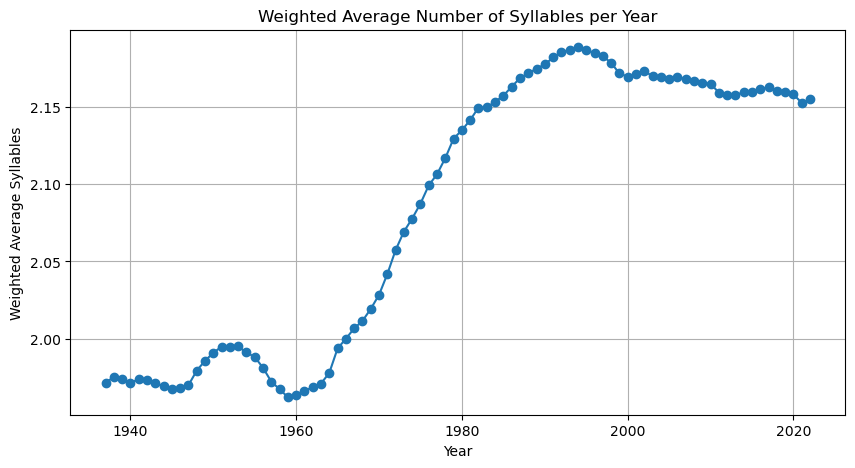

In [10]:
df3['total_syllables'] = df3['count'] * df3['num_syllables']
weighted_avg = df3.groupby('year').apply(
    lambda x: x['total_syllables'].sum() / x['count'].sum()
).reset_index(name='weighted_avg_syllables')

plt.figure(figsize=(10, 5))
plt.plot(weighted_avg['year'], weighted_avg['weighted_avg_syllables'], marker='o')
plt.title('Weighted Average Number of Syllables per Year')
plt.xlabel('Year')
plt.ylabel('Weighted Average Syllables')
plt.grid(True)
plt.show()

## (look at other columns, do they seem to matter?)

In [11]:
# add feature: syl_ratio = num_syllables / wtd ave
df4 = df3.merge(weighted_avg, on='year', how='left')
df4['syl_ratio'] = df4['num_syllables'] / df4['weighted_avg_syllables']
df4.drop(columns=['count_sum', 'total_syllables', 'weighted_avg_syllables'], inplace=True)
print('unique names: ', df4['name'].nunique())

# make sure sorted properly, and no NaNs (which should just be for "diff__", so like 1937-1957)
print('shape: ', df4.shape)
df4.sort_values(['name', 'year'], inplace=True)
df4.dropna(how='any', inplace=True)
print('shape after remove NaNs: ', df4.shape)
df4.head()

unique names:  2357
shape:  (202702, 18)
shape after remove NaNs:  (155562, 18)


,year,gender,count,name,perc,diff1,diff2,diff3,diff5,diff10,diff20,accel,starts_with_vowel,ends_with_vowel,ends_with_y,ends_with_ah,num_syllables,syl_ratio
20,1957,0,1347,Aaron_M,0.034366,0.001230,0.005192,0.008374,0.008145,0.014270,0.010773,-0.002732,1,0,0,0,2,1.013995
21,1958,0,1403,Aaron_M,0.036559,0.002193,0.003423,0.007385,0.011742,0.014999,0.013316,0.000962,1,0,0,0,2,1.016497
22,1959,0,1542,Aaron_M,0.040072,0.003514,0.005706,0.006936,0.014081,0.015897,0.017071,0.001321,1,0,0,0,2,1.019193
23,1960,0,1771,Aaron_M,0.046142,0.006070,0.009584,0.011776,0.016968,0.021993,0.022161,0.002556,1,0,0,0,2,1.018347
24,1961,0,1884,Aaron_M,0.049339,0.003197,0.009267,0.012780,0.016203,0.024477,0.024631,-0.002873,1,0,0,0,2,1.017012


In [12]:
label_encoder = LabelEncoder()
df4['name_id'] = label_encoder.fit_transform(df4['name'])

## model

In [13]:
df5 = df4.copy()

In [14]:
# I'm going to worry about perc for now, not count
df5.drop(['count'], axis=1, inplace=True)
# using name_id, not name
df5.drop(['name'], axis=1, inplace=True)

In [15]:
# df5.head()

In [16]:
# normalize numeric (not year - see below)
features_to_normalize = list(df5.columns)
features_to_normalize.remove('name_id')
features_to_normalize.remove('gender')
features_to_normalize.remove('starts_with_vowel')
features_to_normalize.remove('ends_with_vowel')
features_to_normalize.remove('ends_with_y')
features_to_normalize.remove('ends_with_ah')
# features_to_normalize

In [17]:
# features_to_normalize = ['perc', 'diff1', 'diff2', 'diff3', 'diff5', 'diff10', 'diff20', 'accel', 'num_syllables', 'syl_ratio']
scaler = MinMaxScaler()
df5[features_to_normalize] = scaler.fit_transform(df5[features_to_normalize])

In [18]:
sequence_length = 10

In [19]:
def create_sequences(df, sequence_length):
    X = []
    y = []

    grouped = df.groupby("name_id")
    col_list = list(df.columns)
    col_list.remove('name_id')

    for _, group in grouped:
        values = group.sort_values(by="name_id")[col_list].values
        
        for i in range(len(values) - sequence_length):
            X.append(values[i:i + sequence_length])
            y.append(values[i + sequence_length, 1])  # Assuming 'perc' is at index 1

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    return X, y

In [20]:
train_df = df5.copy()[df5['year'] <= 2020]
test_df = df5.copy()[df5['year'] >= 2021]

train_df.drop(['year'], axis=1, inplace=True)
test_df.drop(['year'], axis=1, inplace=True)

train_X, train_y = create_sequences(train_df, sequence_length)
test_X, test_y = create_sequences(test_df, sequence_length)

In [21]:
# sorted by year, but don't need it as a feature
# df5.drop(['year'], axis=1, inplace=True)

In [30]:
num_names = train_df['name_id'].nunique()

# Model definition
model = Sequential([
    InputLayer(shape=(sequence_length,)),
    Embedding(input_dim=num_names + 1, output_dim=50), # input_length=sequence_length
    GRU(64, return_sequences=True),
    GRU(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 10, 50)         │       117,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 10, 64)         │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,357 (661.55 KB)

 Trainable params: 169,357 (661.55 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(train_X, train_y, epochs=20, validation_split=0.1, batch_size=32)

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 10, 15), dtype=float32). Expected shape (None, 10), but input has incompatible shape (None, 10, 15)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 10, 15), dtype=float32)
  • training=True
  • mask=None

In [34]:
num_unique_names = len(test_df['name_id'].unique())

In [35]:
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Embedding(num_unique_names, hp.Int('embedding_dim', min_value=5, max_value=50, step=5), input_length=hp.Int('sequence_length', min_value=1, max_value=10, step=1)))
        model.add(GRU(units=hp.Int('units', min_value=16, max_value=128, step=16)))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse')
        return model

hypermodel = MyHyperModel()

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='name_prediction'
)

tuner.search(train_X, train-y, epochs=10, validation_data=(x_val, y_val))
best_model = tuner.get_best_models(num_models=1)[0]

ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 1}

In [33]:
# split by year
# then consider dropping the year column. 
#     GRUs are sensitive to the order of data but year column as a feature is not necessary


In [34]:
train_df.columns

Index(['gender', 'name', 'perc', 'diff1', 'diff2', 'diff3', 'diff5', 'diff10',
       'diff20', 'accel', 'starts_with_vowel', 'ends_with_vowel',
       'ends_with_y', 'ends_with_ah', 'num_syllables', 'syl_ratio', 'name_id'],
      dtype='object')

In [35]:
test_df.head()

,gender,name,perc,diff1,diff2,diff3,diff5,diff10,diff20,accel,starts_with_vowel,ends_with_vowel,ends_with_y,ends_with_ah,num_syllables,syl_ratio,name_id
84,0,Aaron_M,0.103813,0.378155,0.346600,0.316332,0.329933,0.444593,0.498883,0.520979,1,0,0,0,0.25,0.225843,0
85,0,Aaron_M,0.097606,0.376324,0.340192,0.316540,0.318394,0.440824,0.499202,0.529774,1,0,0,0,0.25,0.225376,0
170,1,Abbie_F,0.002055,0.400003,0.364114,0.337726,0.358832,0.467412,0.520803,0.532322,1,1,0,0,0.25,0.225843,1
171,1,Abbie_F,0.001712,0.397978,0.363352,0.338002,0.359404,0.467113,0.520661,0.529570,1,1,0,0,0.25,0.225376,1
256,1,Abby_F,0.011169,0.393334,0.360768,0.335533,0.357697,0.464430,0.513141,0.524914,1,0,1,0,0.25,0.225843,2


In [27]:
class NamePredictionHyperModel(HyperModel):
    def __init__(self, num_names, num_features, sequence_length):
        self.num_names = num_names
        self.num_features = num_features
        self.sequence_length = sequence_length
    
    def build(self, hp):
        name_input = Input(shape=(1,), name='name_input')
        features_input = Input(shape=(self.sequence_length, self.num_features), name='features_input')

        name_embedding = Embedding(
            input_dim=self.num_names + 1, 
            output_dim=hp.Int('embedding_dim', min_value=10, max_value=50, step=10),
            input_length=1)(name_input)
        name_embedding = Flatten()(name_embedding)

        x = GRU(
            hp.Int('gru_units_1', min_value=32, max_value=128, step=32), 
            return_sequences=True)(features_input)
        x = GRU(
            hp.Int('gru_units_2', min_value=32, max_value=128, step=32))(x)

        concatenated = Concatenate()([x, name_embedding])
        output = Dense(1, activation='linear')(concatenated)

        model = Model(inputs=[features_input, name_input], outputs=output)
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

NameError: name 'dftemp' is not defined

In [29]:
num_names = train_df['name'].nunique()
num_names

2357

In [35]:
# num_features do not include perc, and name (which I anm embedding) 
num_features = train_df.shape[1] - 2
num_features

14

## this should be changed to make sure sequences don't split names (might hurt training), also try to include sequence_length in tuning 

In [36]:
sequence_length = 4 # 

In [37]:
# Configure the tuner
tuner = RandomSearch(
    NamePredictionHyperModel(num_names, num_features, sequence_length),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir3',
    project_name='name_prediction3'
)

ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 1}

In [ ]:
# Display search space summary
tuner.search_space_summary()

In [ ]:
# Perform the hyperparameter tuning
tuner.search(x=[X_train, names_train], y=y_train, epochs=10, validation_data=([X_val, names_val], y_val))

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

In [ ]:
# Reshape data for GRU layer: GRU expects 3D shape [batch, timesteps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
model = Sequential([
    GRU(32, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(16, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, batch_size=64, verbose=1)

In [ ]:
test_loss = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {test_loss}')

In [ ]:
predictions = model.predict(X_test_scaled)

#### 